In [2]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

%pip install -Uqq fastai "duckduckgo_search>=6.2"

Note: you may need to restart the kernel to use updated packages.


In [3]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

/opt/homebrew/Caskroom/miniconda/base/envs/fastai/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniconda/base/envs/fastai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/homebrew/Caskroom/miniconda/base/envs/fastai/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <C62FA868-4C49-3B20-AFA6-2F7F59A295B4> /opt/homebrew/Caskroom/miniconda/base/envs/fastai/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


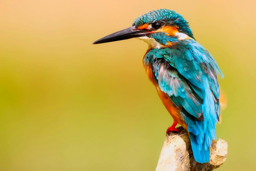

In [5]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

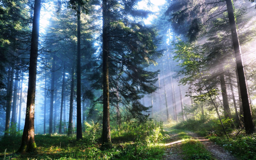

In [6]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [8]:
searches = 'forest','bird'
path = Path('bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

10

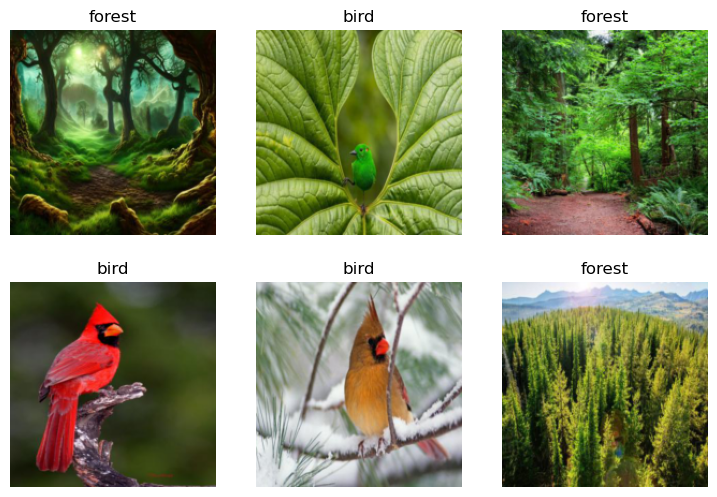

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.269725,0.000067,0.000000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.006448,0.000033,0.000000,00:03
1,0.002951,0.000001,0.000000,00:03
2,0.002972,0.000001,0.000000,00:03


In [12]:
type,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {type}.")
print(f"Probability it's a {type}: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


In [13]:
type,_,probs = learn.predict(PILImage.create('forest.jpg'))
print(f"This is a: {type}.")
print(f"Probability it's a forest: {probs[1]:.4f}")

This is a: forest.
Probability it's a forest: 1.0000


# Prepare the model for use in an application

In [15]:
# export the model for use in an application (export.pkl)
learn.export()

In [16]:
# load the model for use in an application
learn_inf = load_learner('export.pkl')

In [19]:
# print the model's vocabulary
learn_inf.dls.vocab

['bird', 'forest']

In [20]:
learn_inf.predict('bird.jpg')

('bird', tensor(0), tensor([1.0000e+00, 3.4342e-10]))

# Create an application to use the model

In [23]:
! pip install -Uqq fastai
from fastai import *
from fastai.vision.widgets import *

btn_upload = widgets.FileUpload()
btn_upload


FileUpload(value=(), description='Upload')

In [51]:
import io

# create a button to do classification
btn_run = widgets.Button(description='Classify')
btn_run

# display the prediction via labels
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

def on_click_classify(change):
    uploaded_file = btn_upload.value[0]
    img = PILImage.create(io.BytesIO(uploaded_file.content.tobytes()))
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)


In [52]:
VBox([widgets.Label('Select your image!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [53]:
!pip install voila
!jupyter server extension enable --sys-prefix voila

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 45.7 MB/s eta 0:00:00
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook run server troubleshoot trust

Jupyter command `jupyter-serverextension` not found.
